# Real-time optimization with Modifier Adapation using Gaussian Processes
## Preliminary results
A simple experiment was run to investigate the effect of the optimizer choice on the RTO convergence results. The following algorithms from the `scipy` package were evaluated:
- SLSQP: https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp
- Differentation evolution: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html

For the DE algorithm, it was considered the `best1bin` and `rand1bin` strategies, population size of 20 individuals and a maximum of 50 generations. The `polish` option was deactivated, so the results are only from the stochastic algorithm.

For each rto cycle consisting of 120 iterations, the process starts at a random feasible operating point around `u = [10.6521, 0.0005141, 224.4806]`, where 5 random operating points are also chosen for initialization of the Gaussian Process estimator. A gaussian noise of `0.01%` was added to the plant measurements. This was executed 20 times for each optimization algorithm evaluated. 



In [1]:
# First, let's import some necessary stuff
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.style.use('ggplot')

# add the parent folder to path
lib_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(lib_path)

from bussineslogic.rto_data import RTODataModel
md_exact = RTODataModel('/mnt/d/rto_data/rto_poc_exact.db')
md_derand = RTODataModel('/mnt/d/rto_data/rto_poc_derand1bin.db')
md_debest = RTODataModel('/mnt/d/rto_data/rto_poc_debest1bin.db')

# The real plant optimum
u_plant = [18.6139787, 0.00110823, 227.6375114]
f_plant = -0.5085

## Data Preparation

In [2]:
# Now, let's load the results data
# Then load the results
all_results_exact = pd.DataFrame(md_exact.get_rto_experiment_results('ma-gp-slsqp_scipy'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id','iteration', 'var_name', 'value'])
all_results_debest = pd.DataFrame(md_debest.get_rto_experiment_results('ma-gp-de_scipy_best1bin'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id','iteration', 'var_name', 'value'])
all_results_derand = pd.DataFrame(md_derand.get_rto_experiment_results('ma-gp-de_scipy_rand1bin'), columns=['rto.id', 'rto.name', 'rto.type', 'run.id','iteration', 'var_name', 'value'])

In [18]:
# After that, preprocess the DB data
def aggfunc(x):
    return x
# Define a helper function to perform the calculations
def pre_process_results(all_results):
    # Transform the data
    all_results_pv = pd.pivot_table(all_results, values='value', index=['run.id','iteration','rto.type'], columns=['var_name'], aggfunc=aggfunc)
    all_results_pv.reset_index(level=all_results_pv.index.names, inplace=True)

    # Convert the values
    #all_results_pv[['cost_model','cost_real','fobj_modifier']] = pd.to_numeric(all_results_pv[['cost_model','cost_real','fobj_modifier']])
    all_results_pv[['cost_model','cost_real','fobj_modifier']] = all_results_pv[['cost_model','cost_real','fobj_modifier']].astype('float')

    # Extract some variables
    all_results_pv['g_0'] = all_results_pv['g_real'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1'] = all_results_pv['g_real'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['g_0_model'] = all_results_pv['g_model'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1_model'] = all_results_pv['g_model'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['g_0_modifiers'] = all_results_pv['g_modifiers'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['g_1_modifiers'] = all_results_pv['g_modifiers'].apply(lambda x: float(x.split(',')[1])) 

    all_results_pv['tm'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[0])) 
    all_results_pv['Fs'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[1])) 
    all_results_pv['ts'] = all_results_pv['u'].apply(lambda x: float(x.split(',')[2])) 

    # kpis
    all_results_pv['du'] = all_results_pv[['tm','Fs','ts']].apply(lambda x: np.linalg.norm(100 * (x - u_plant)/u_plant), axis=1)
    all_results_pv['dPhi'] = all_results_pv[['cost_real']].apply(lambda x: 100 * (x - f_plant)/f_plant)
    all_results_pv['g_Cb_tf'] = all_results_pv['g_0'].apply(lambda x: 'Not violated' if x <= 0.025 else 'Violated')
    all_results_pv['g_Cd_tf'] = all_results_pv['g_1'].apply(lambda x: 'Not violated' if x <= 0.15 else 'Violated')

    return all_results_pv

In [19]:
# Now apply the transformation
results_exact = pre_process_results(all_results_exact)
results_debest = pre_process_results(all_results_debest)
results_derand = pre_process_results(all_results_derand)

# Join the as a single dataframe
results_all = pd.concat([results_exact, results_debest, results_derand], ignore_index=True)

## Results

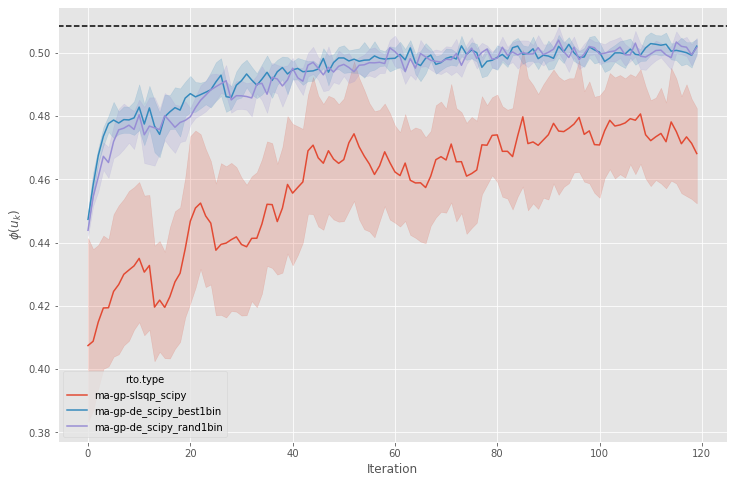

In [31]:
# Plot the convergence results for objective function
neg_mean = lambda x: -np.mean(x)

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=results_all, y='cost_real', x='iteration', hue='rto.type', ax=ax, estimator=neg_mean)
ax.axhline(-f_plant, linestyle='--', color='k')
ax.set_xlabel('Iteration')
ax.set_ylabel('$\phi(u_k)$')
fig.show()


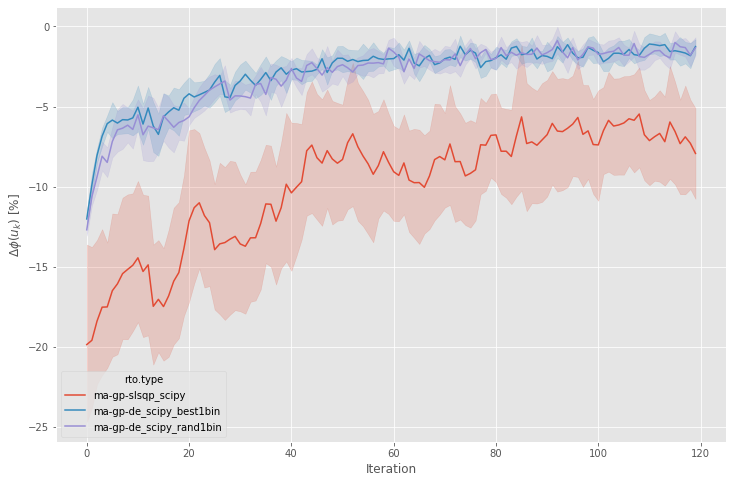

In [34]:
# Plot the convergence results for dPhi
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=results_all, y='dPhi', x='iteration', hue='rto.type', ax=ax)
ax.set_xlabel('Iteration')
ax.set_ylabel('$\Delta \phi(u_k)$ [\%]')
fig.show()


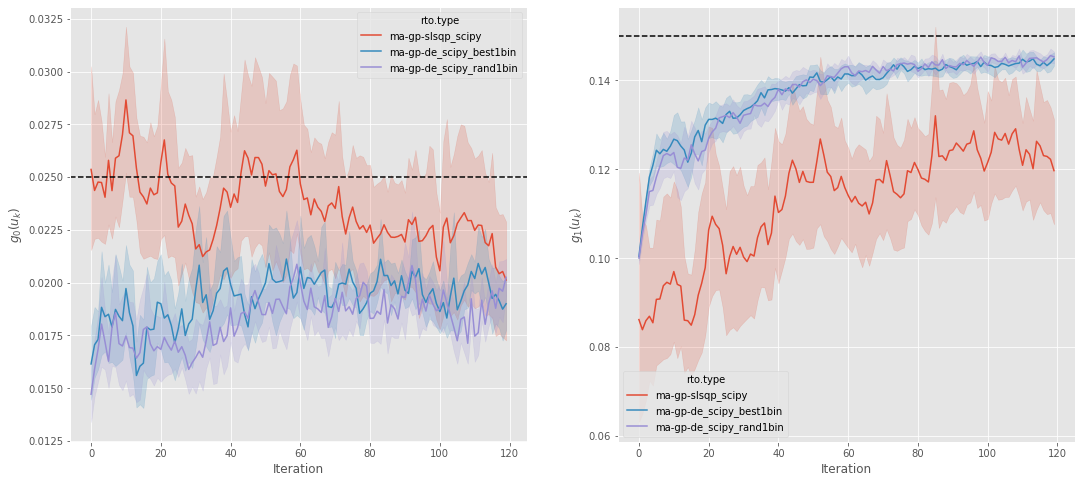

In [37]:
# Plot the convergence results for constraints
fig, ax = plt.subplots(1,2, figsize=(18,8), sharex=True)
sns.lineplot(data=results_all, y='g_0', x='iteration', hue='rto.type', ax=ax[0])
ax[0].axhline(0.025, linestyle='--', color='k')
sns.lineplot(data=results_all, y='g_1', x='iteration', hue='rto.type', ax=ax[1])
ax[1].axhline(0.15, linestyle='--', color='k')
ax[0].set_xlabel('Iteration')
ax[1].set_xlabel('Iteration')
ax[0].set_ylabel('$g_0(u_k)$')
ax[1].set_ylabel('$g_1(u_k)$')
fig.show()

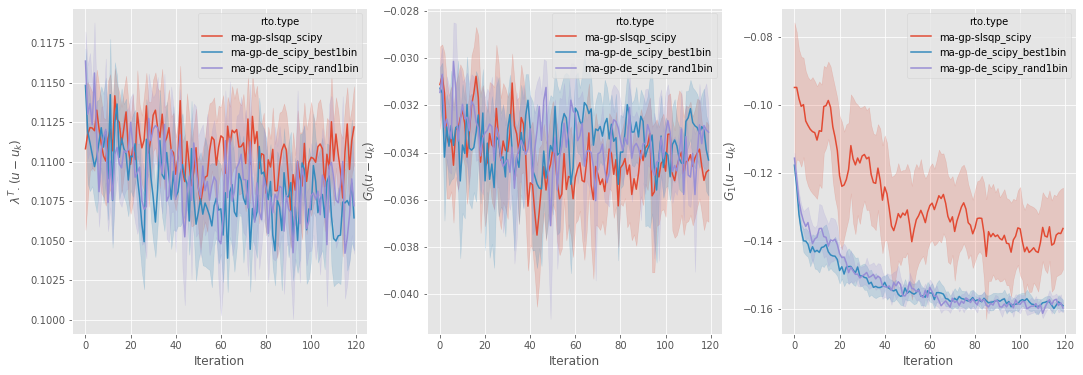

In [40]:
# Plot the cost modifier estimation
fig, ax = plt.subplots(1,3, figsize=(18,6), sharex=True)
sns.lineplot(data=results_all, y='fobj_modifier', x='iteration', hue='rto.type', ax=ax[0])
sns.lineplot(data=results_all, y='g_0_modifiers', x='iteration', hue='rto.type', ax=ax[1])
sns.lineplot(data=results_all, y='g_1_modifiers', x='iteration', hue='rto.type', ax=ax[2])
ax[0].set_ylabel('$\lambda^T . (u - u_k)$')
ax[1].set_ylabel('$G_0(u - u_k)$')
ax[2].set_ylabel('$G_1(u - u_k)$')
ax[0].set_xlabel('Iteration')
ax[1].set_xlabel('Iteration')
ax[2].set_xlabel('Iteration')
fig.show()

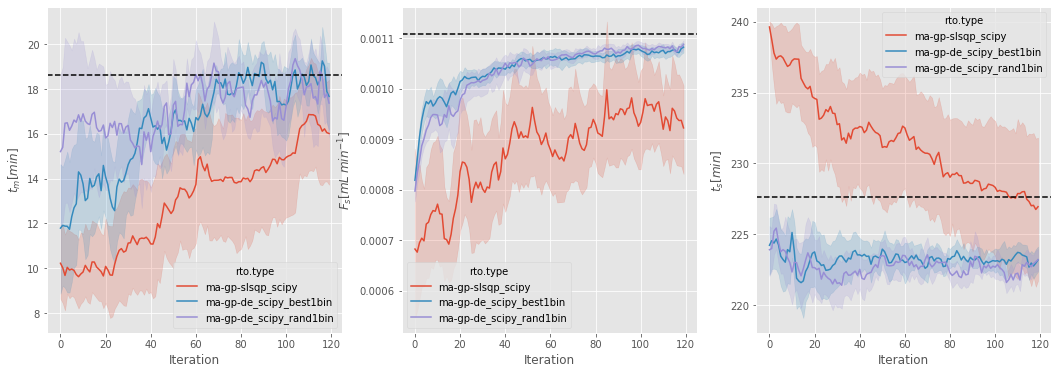

In [41]:
# Plot the convergence results for the input signal
fig, ax = plt.subplots(1,3, figsize=(18,6), sharex=True)
sns.lineplot(data=results_all, y='tm', x='iteration', hue='rto.type', ax=ax[0])
sns.lineplot(data=results_all, y='Fs', x='iteration', hue='rto.type', ax=ax[1])
sns.lineplot(data=results_all, y='ts', x='iteration', hue='rto.type', ax=ax[2])
ax[0].axhline(u_plant[0], linestyle='--', color='k')
ax[1].axhline(u_plant[1], linestyle='--', color='k')
ax[2].axhline(u_plant[2], linestyle='--', color='k')

ax[0].set_xlabel('Iteration')
ax[1].set_xlabel('Iteration')
ax[2].set_xlabel('Iteration')
ax[0].set_ylabel('$t_m [min]$')
ax[1].set_ylabel('$F_s [mL \: min^{-1}]$')
ax[2].set_ylabel('$t_s [min]$')
fig.show()


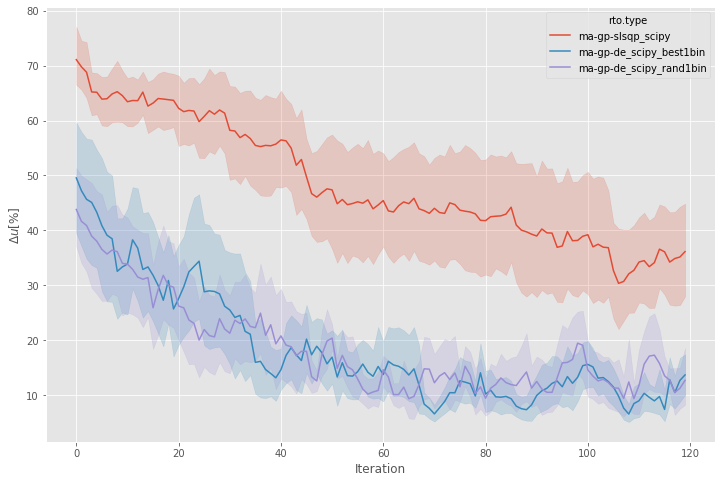

In [44]:
# Plot the convergence results for the input signal difference
fig, ax2 = plt.subplots(figsize=(12,8))
sns.lineplot(data=results_all, y='du', x='iteration', hue='rto.type', ax=ax2)
ax2.set_ylabel('$\Delta u [\%] $')
ax2.set_xlabel('Iteration')
fig.show()

## Conclusion

The choice of the optimizer makes a lot of difference on the convergence results for the RTO system using MA with Gaussian Processes. It was possible to see that changes in the initial operating point can make the exact algorithm have poor results due to it being trapped into local minimina in the search process, which was not observed for the stochastic algorithms evaluated. In fact, for the stochastic algorithms, the choice of the initial operating point does not affect it at all, and they display a very consistent convergence profile.

One important thing to notice is that all algorithms could not converge to the true plant optimum, achieving and optimality gap of around 2% for the stochastic algorithms and 7% for SLSQP. This can be explained by the noise introduced during the experiments, an overfitting of the GP regression model or inadequacy of the model, which might not respect the second order optimality conditions.

